In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs available")

1 Physical GPUs, 1 Logical GPUs


2024-07-20 07:07:57.661342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-20 07:07:57.666279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-20 07:07:57.666434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-20 07:07:57.668016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


In [4]:
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [5]:
print("TensorFlow version:", tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.6.0
Num GPUs Available:  1


In [6]:
os.getcwd()

'/workspace/notebooks'

In [7]:
# Get the directory of the current script
cwd = os.getcwd()

# Construct the path to the CSV file
input_path = os.path.join(cwd,'../','data', 'raw', 'HAM10000_metadata.csv')

data_pd = pd.read_csv(input_path)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [9]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [10]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [11]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [12]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [13]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [14]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [15]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
2850,HAM_0007611,ISIC_0032314,bcc,histo,85.0,male,back,no
3846,HAM_0007201,ISIC_0026208,nv,follow_up,50.0,male,lower extremity,no
2046,HAM_0000075,ISIC_0025651,mel,histo,70.0,male,back,no
5819,HAM_0006035,ISIC_0027551,nv,follow_up,65.0,male,back,no
5627,HAM_0001783,ISIC_0029256,nv,follow_up,50.0,male,abdomen,no


In [16]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [17]:
len(test_list)

828

In [18]:
len(train_list)

9187

In [19]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [20]:
# create a train directory
train_dir = os.path.join(cwd, '../', 'data', 'processed', 'train')
os.makedirs(train_dir, exist_ok=True)

# create a test directory
test_dir = os.path.join(cwd, '../', 'data', 'processed', 'test')
os.makedirs(test_dir, exist_ok=True)

In [21]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [22]:
for i in targetnames:
    directory1 = os.path.join(train_dir, i)
    directory2 = os.path.join(test_dir, i)

    os.makedirs(directory1, exist_ok=True)
    os.makedirs(directory2, exist_ok=True)

In [23]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join(cwd,'../', 'data', 'raw', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [24]:

for image in test_list:

    file_name = image+'.jpg'

    #get the label for a given image
    label = data_pd.loc[image, 'dx']
    
    # path of source image 
    source = os.path.join(cwd,'../', 'data', 'raw', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [25]:
## Processed images

In [26]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    img_class_dir = os.path.join(train_dir,img_class)
    img_list = os.listdir(img_class_dir)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join(train_dir  , img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = os.path.join(train_dir,img_class)

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [27]:
train_path = train_dir 
test_path = test_dir
batch_size = 16

In [28]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [29]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [30]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [31]:
#import ssl
# Bypass SSL verification
#ssl._create_default_https_context = ssl._create_unverified_context


In [32]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


## SOFT ATTENTION

In [33]:

attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)



In [34]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [37]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath ='IRV2+SA.h5',
                             monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [38]:
# Define your SoftAttention layer or function
class SoftAttention(Layer):
    def call(self, x):
        exp_x = tf.expand_dims(x, axis=1)  # Use tf.expand_dims
        C3d = tf.keras.layers.Conv3D(
            filters=32,
            kernel_size=(1, 1, x.shape[-1]),  # Ensure x.shape is used correctly
            strides=(1, 1, x.shape[-1]),  # Ensure x.shape is used correctly
            padding='same',
            data_format='channels_last'
        )(exp_x)
        return C3d

## TRAINING

In [39]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.0001)

# Calculate steps per epoch and validation steps
steps_per_epoch = int(len(train_df) / 10)  # Convert to integer
validation_steps = int(len(test_df) / batch_size)  # Convert to integer

history = model.fit(train_batches,
                    steps_per_epoch=steps_per_epoch,
                    epochs=150,
                    verbose=2,
                    validation_data=test_batches,validation_steps=validation_steps,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/150


2024-07-20 07:20:30.565237: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-07-20 07:20:39.137297: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2024-07-20 07:20:39.325981: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-20 07:20:39.326540: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-20 07:20:39.326568: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2024-07-20 07:20:39.327233: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-20 07:20:39.327338: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

918/918 - 314s - loss: 1.9024 - accuracy: 0.4807 - val_loss: 6.6030 - val_accuracy: 0.1397
Epoch 2/150
918/918 - 303s - loss: 1.3456 - accuracy: 0.6077 - val_loss: 0.5694 - val_accuracy: 0.8039
Epoch 3/150
918/918 - 302s - loss: 1.0562 - accuracy: 0.6957 - val_loss: 0.4521 - val_accuracy: 0.8100
Epoch 4/150
918/918 - 302s - loss: 0.9581 - accuracy: 0.7216 - val_loss: 0.4052 - val_accuracy: 0.8603
Epoch 5/150
918/918 - 302s - loss: 0.8148 - accuracy: 0.7635 - val_loss: 0.3811 - val_accuracy: 0.8505
Epoch 6/150
918/918 - 302s - loss: 0.7101 - accuracy: 0.7983 - val_loss: 0.4601 - val_accuracy: 0.8186
Epoch 7/150
918/918 - 301s - loss: 0.6682 - accuracy: 0.8134 - val_loss: 0.4610 - val_accuracy: 0.8407
Epoch 8/150
918/918 - 302s - loss: 0.6313 - accuracy: 0.8239 - val_loss: 0.4105 - val_accuracy: 0.8713
Epoch 9/150
918/918 - 301s - loss: 0.5858 - accuracy: 0.8389 - val_loss: 0.3880 - val_accuracy: 0.8627
Epoch 10/150
918/918 - 302s - loss: 0.5316 - accuracy: 0.8519 - val_loss: 0.3251 - va

In [40]:
from tensorflow.keras import models


In [41]:
model.save_weights('IRV2+SA.hdf5')

In [42]:

#model.load_weights("IRV2+SA.hdf5")

In [43]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [44]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.61      0.67        23
         bcc       0.77      0.88      0.82        26
         bkl       0.71      0.55      0.62        66
          df       0.40      0.33      0.36         6
         mel       0.39      0.50      0.44        34
          nv       0.94      0.96      0.95       663
        vasc       1.00      0.70      0.82        10

    accuracy                           0.89       828
   macro avg       0.71      0.65      0.67       828
weighted avg       0.89      0.89      0.88       828



In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.887094479778135
Recall: 0.8852657004830918
Accuracy: 0.8852657004830918
weighted Roc score: 0.9655568821057667


In [46]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7056010203124312
Recall: 0.6469083346321198
Accuracy: 0.8852657004830918
Macro Roc score: 0.9646271647657506


In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8852657004830918
Recall: 0.8852657004830918
Accuracy: 0.8852657004830918
Micro Roc score: 0.9911887772565676


In [48]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9836889008911693
The ROC AUC score of bcc is: 0.9973144062919623
The ROC AUC score of bkl is: 0.9620814443649088
The ROC AUC score of df is: 0.8996350364963503
The ROC AUC score of mel is: 0.9449918506445399
The ROC AUC score of nv is: 0.9651675122263358
The ROC AUC score of vasc is: 0.9995110024449878


In [49]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

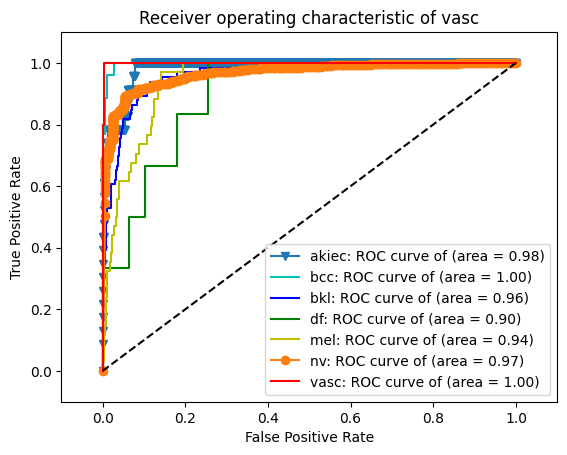

In [50]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [51]:
x_test,y_test=next(test_batches)

In [52]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)

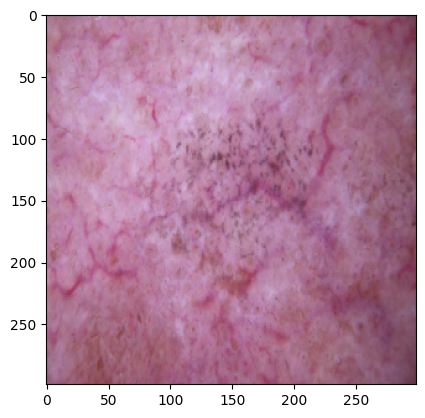

In [53]:
img_idx = 0
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
plt.imshow(t[img_idx])

In [54]:
sum_attnmap = np.sum(sa_maps[img_idx],0)
sum_attnmap.shape

(8, 8)

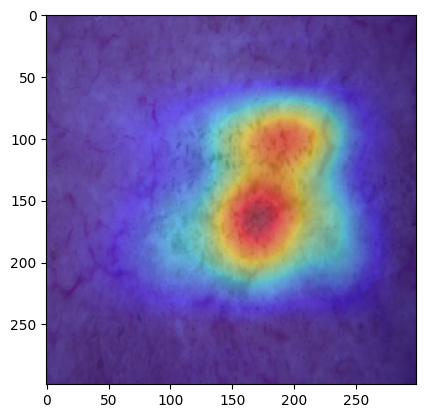

In [55]:
plt.imshow(t[img_idx],alpha=1.0)
plt.imshow(cv2.resize(sum_attnmap,(299,299),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()